### Totally Wired BBQ

Here we will use the [Fireboard BBQ Thermometer](https://www.fireboard.com/shop/fireboard-fbx11-thermometer/) to monitor the progress of some beef short ribs smoking on the Weber Smoky Mountain.


In [54]:
import numpy,pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pygam import LinearGAM
import pygam


import seaborn
from datetime import date


%matplotlib inline

import requests
import json
import pandas

target_temp = 203
open_vents=['11:17','11:38','17:00']
close_vents=['13:14']



# function get grab session data

def get_session(verbose=False):
    # load auth data

    auth = json.loads(open('auth.json').readlines()[0])

    # first get session data

    response = requests.get('https://fireboard.io/api/v1/sessions.json',
                            auth=(auth['username'], auth['password']))
    # this assumes that the first session is the newest - seems correct
    session_info = response.json()[0]

    # grab session chart

    response = requests.get('https://fireboard.io/api/v1/sessions/%d/chart.json'%session_info['id'],
                            auth=(auth['username'], auth['password']))
    session_data = response.json()
    
    # print channels
    if verbose:
        print('Detected %d channels'%len(session_data))
        for i,s in enumerate(session_data):
            print("channel %d: %s"%(i,s['label']))
            
    # this assumes that air temp is probe 1 and the rest are meat temps
    offset=8*3600
    session_df = pandas.DataFrame({'Air (%s)'%session_data[0]['label'].replace('Channel','Probe'):session_data[0]['y']},
                   # need to correct date stamp to match pacific time
                    index=pandas.to_datetime([i - offset for i in session_data[0]['x']],
                                                            unit='s')).tz_localize(tz='US/Pacific')

    for i in range(1,len(session_data)):
        session_df['Meat (%s)'%session_data[i]['label'].replace('Channel','Probe')]=session_data[i]['y']
 
    return(session_df)



Current temps:
Air (Probe 1)     256.3
Meat (Probe 2)    202.9
Meat (Probe 3)    197.3
Name: 2019-01-01 17:36:35-08:00, dtype: float64


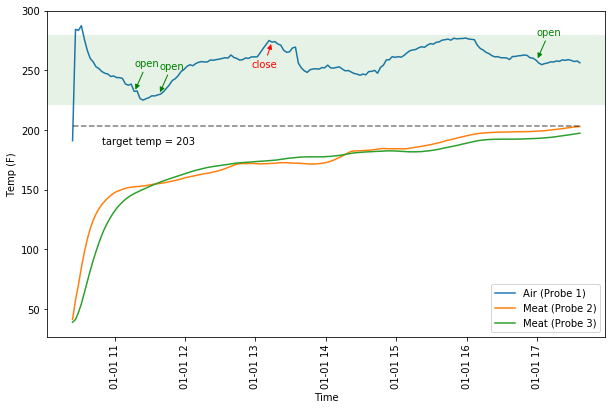

In [55]:
s = get_session()

def mk_plot(s,open_vents,close_vents):
    plt.figure(figsize=(10,6))
    today = str(date.today())

    opentimes = [pandas.to_datetime('%s %s'%(today,i), dayfirst=True).tz_localize(tz='US/Pacific') for i in open_vents]
    closetimes = [pandas.to_datetime('%s %s'%(today,i), dayfirst=True).tz_localize(tz='US/Pacific') for i in close_vents]

    vent_changes = {}
    for o in opentimes:
        vent_changes[o]='open'
    for c in closetimes:
        vent_changes[c]='close'



    plt.plot(s)
    plt.legend(s.columns)
    plt.xlabel('Time')
    _=plt.ylabel("Temp (F)")

    target_temp = 203

    # draw range for air temp
    plt.plot([s.index.min(),s.index.max()],[250,250],
             linewidth=70,alpha=0.1,color='green')

    plt.plot([s.index.min(),s.index.max()],[target_temp,target_temp],
             '--',color='k',alpha=0.5)

    plt.text(s.index[10],target_temp-15,
             'target temp = %d'%target_temp)

    ax=plt.gca()
    props = {"rotation" : 90}
    plt.setp(ax.get_xticklabels(), **props)

    xytext_dict = {'open':(0, 25),
                   'close':(-20,-25)}
    color_dict={'open':'green',
                   'close':'red'}

    for o in vent_changes:
        # find closest time stamp
        stamp = s.index.get_loc(o,method='nearest')
        ax.annotate(vent_changes[o], (mdates.date2num(o), 
                             s.iloc[stamp]['Air (Probe 1)']), 
                xytext=xytext_dict[vent_changes[o]], 
                textcoords='offset points', 
                arrowprops=dict(color=color_dict[vent_changes[o]],
                                arrowstyle='-|>'),
                color=color_dict[vent_changes[o]])

    plt.savefig('shortribs.png')
    
mk_plot(s,open_vents,close_vents)
print('Current temps:')
print(s.iloc[-1,:])

Predict finishing time using Generalized Additive Model.  We fit models with a range of regularization to get an estimate of the range of possible finishing times.

predicted to hit target temp between: 2019-01-01 17:59:10-08:00 and 2019-01-01 18:39:10-08:00


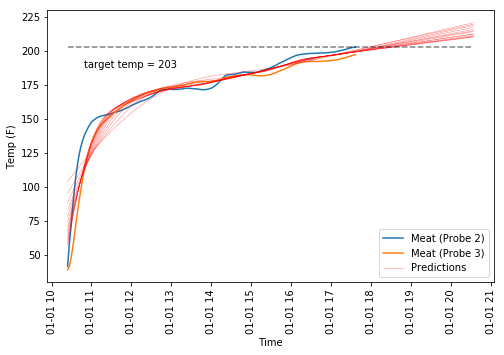

In [56]:
# fit GAM to existing data

timestamps = [i/1e9 for i in pandas.to_numeric(s.index).tolist()]

X = numpy.zeros((len(timestamps),1))
X[:,0]=timestamps
X = X - X[0]

y = s.iloc[:,1:].mean(1)

# fit models for various levels of smoothing
models = {}
for i in range(6,19):
    models[i] = LinearGAM(pygam.s(0),n_splines=i)
    models[i].fit(X, y)# find timepoint where temp hits target

prediction_times = pandas.date_range(start=s.index[0],
                                     end=s.index[-1]+pandas.Timedelta('3 hours'),
                                    freq=s.index[1]-s.index[0])

timestamps_pred = [i/1e9 for i in pandas.to_numeric(prediction_times).tolist()]

X_pred= numpy.zeros((len(timestamps_pred),1))
X_pred[:,0]=timestamps_pred
X_pred = X_pred - X_pred[0]

pred_times=[]
for m in models:
    tpred = models[m].predict(X_pred)
    exc_time = numpy.where(tpred>target_temp)[0]
    if len(exc_time)>0:
        pred_times.append(prediction_times[exc_time[0]])

print('predicted to hit target temp between:',numpy.min(pred_times),'and',numpy.max(pred_times))

# plot prediction against data

plt.figure(figsize=(8,5))
plt.plot(s.iloc[:,1:])


for m in models:
    plt.plot(prediction_times,models[m].predict(X_pred),
          color='r',linewidth=.5,alpha=0.5)

plt.legend(s.columns[1:].tolist() + ['Predictions'] )
plt.xlabel('Time')
plt.ylabel("Temp (F)")


plt.plot([prediction_times.min(),prediction_times.max()],[target_temp,target_temp],
         '--',color='k',alpha=0.5)

plt.text(s.index[10],target_temp-15,
         'target temp = %d'%target_temp)

ax=plt.gca()
props = {"rotation" : 90}
_=plt.setp(ax.get_xticklabels(), **props)

